In [110]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, QuantileTransformer, OrdinalEncoder, RobustScaler, PowerTransformer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from itertools import product
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from tqdm.notebook import tqdm
from itertools import product

In [ ]:
%%capture
!pip install autogluon

## Data analysis

In [80]:
train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

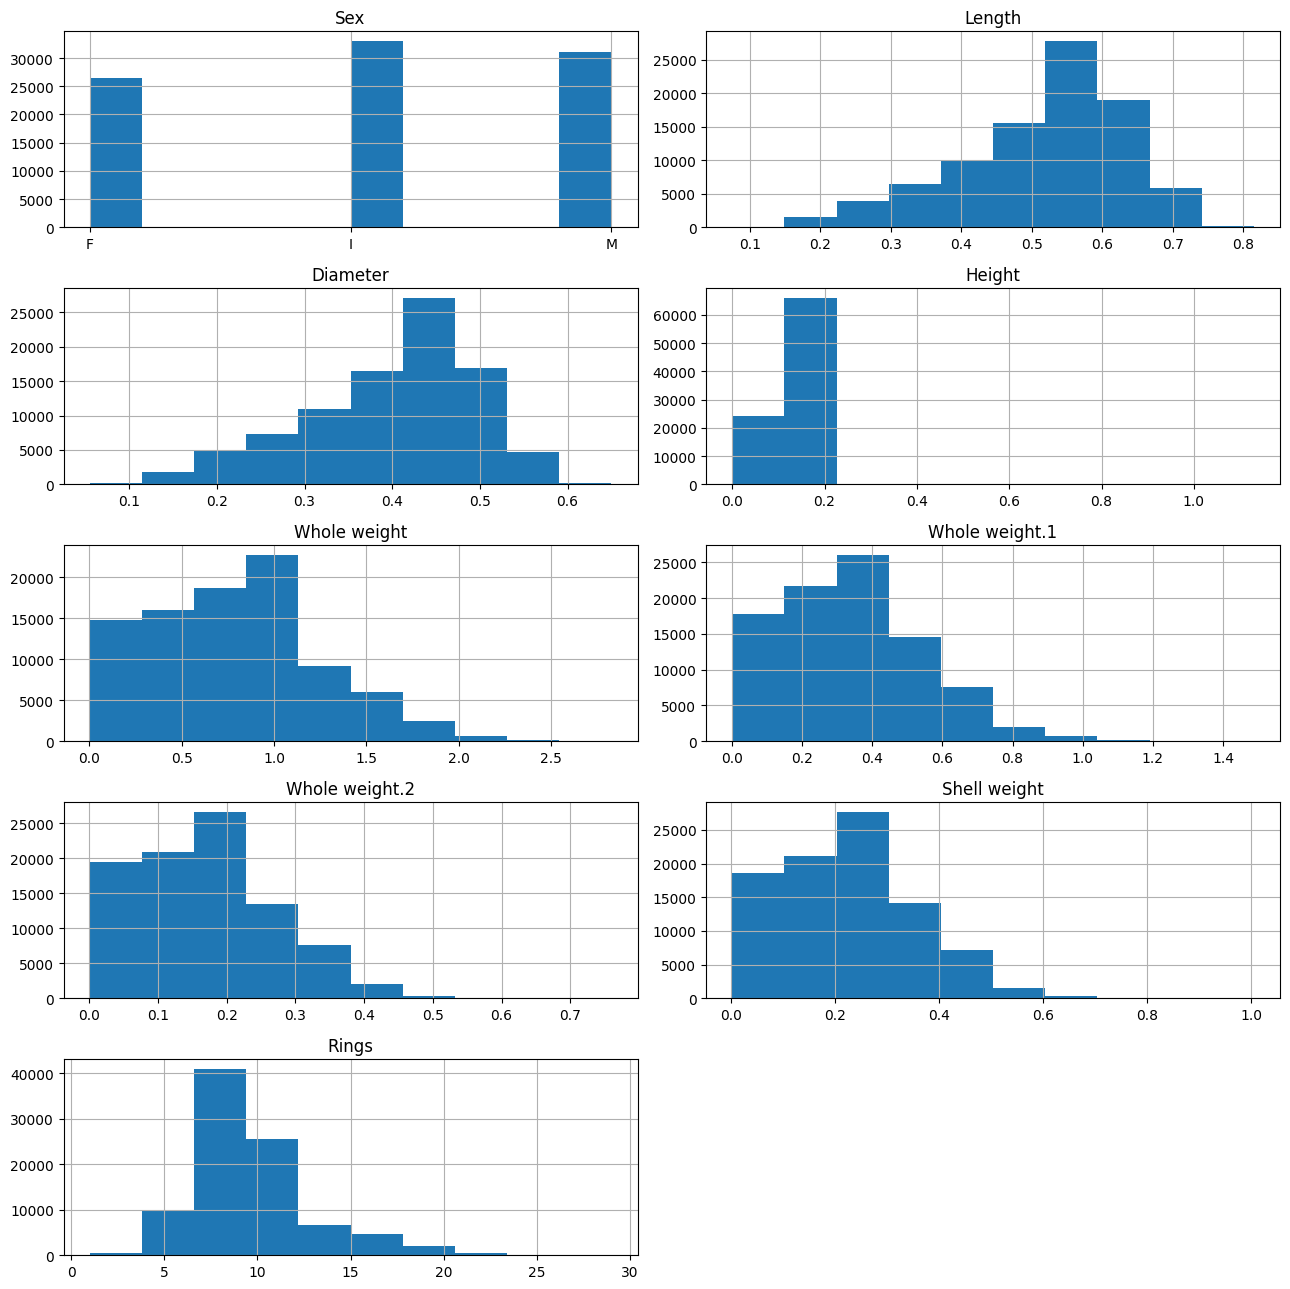

In [45]:
# Calculate the number of rows and columns for subplots
feat_count = len(train.columns)
rows = math.ceil(feat_count / 2)  # Calculate the number of rows
cols = 2  # Fixed number of columns (2 per row)

# Create subplots
fig, ax = plt.subplots(rows, cols, figsize=(13, 13))

# Flatten the axes array for easier iteration
ax = ax.flatten()

# Enumerate over columns and plot histograms
for i, column in enumerate(train.columns):
    ax[i].hist(train[column])
    ax[i].set_title(column)
    ax[i].grid()

# Hide empty subplots if feat_count is odd
if feat_count % 2 != 0:
    ax[-1].axis('off')

plt.tight_layout()

plt.show()

## Preprocess

In [81]:
categorical_features = ['Sex']
numerical_features = [col for col in train.columns if col not in ['Sex', 'Rings']]

In [82]:
X = train.drop(columns=['Rings'], axis=1)
y = train['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [83]:
# Apply preprocessing sequentially
# Apply ordinal encoding to categorical features
ordinal_encoder = OrdinalEncoder()
X_train_cat_encoded = ordinal_encoder.fit_transform(X_train[categorical_features])
X_test_cat_encoded = ordinal_encoder.transform(X_test[categorical_features])

# Apply quantile transformation to numerical features
quantile_transformer = QuantileTransformer(n_quantiles=100)
X_train_num_transformed = quantile_transformer.fit_transform(X_train[numerical_features])
X_test_num_transformed = quantile_transformer.transform(X_test[numerical_features])

# Concatenate the transformed features
X_train_transformed = np.concatenate((X_train_cat_encoded, X_train_num_transformed), axis=1)
X_test_transformed = np.concatenate((X_test_cat_encoded, X_test_num_transformed), axis=1)

In [84]:
from sklearn.neural_network import MLPRegressor
from time import time

print("Training MLPRegressor...")
tic = time()

mlp_model = MLPRegressor(
    hidden_layer_sizes=(30, 15),
    learning_rate_init=0.01,
    early_stopping=True,
    random_state=0,
)

mlp_model.fit(X_train_transformed, y_train)

print(f"done in {time() - tic:.3f}s")
test_r2_score = mlp_model.score(X_test_transformed, y_test)
print(f"Test R2 score: {test_r2_score:.2f}")

Training MLPRegressor...
done in 13.682s
Test R2 score: 0.64


In [105]:
hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(), ['Sex']),
                                ('num', 'passthrough',
                                 ['Length', 'Diameter', 'Height',
                                  'Whole weight', 'Whole weight.1',
                                  'Whole weight.2', 'Shell weight'])],
                  verbose_feature_names_out=False)

In [106]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=0,
        max_iter=50,
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.785s
Test R2 score: 0.66


In [160]:
class ScalerTesting:
    
    def __init__(self, model, scaler, df):
        self.model = model
        self.scaler = scaler
        self.df = df
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_scaled = None
        self.X_test_scaled = None
    
    def split(self):
        X = self.df.drop(columns=['Rings'], axis=1)
        y = self.df['Rings']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, random_state=24)
        self.X_train_scaled, self.X_test_scaled, _, _ = self.scale()
    
    def scale(self):
        scaler = self.scaler()
        X_train_scaled = scaler.fit_transform(self.X_train)
        X_test_scaled = scaler.transform(self.X_test)
        return X_train_scaled, X_test_scaled, self.y_train, self.y_test

    def fit(self):
        model = self.model()
        model.fit(self.X_train_scaled, self.y_train)
        predictions = model.predict(self.X_test_scaled)
        R2_score = model.score(self.X_test_scaled, self.y_test)
        MSE = mean_squared_error(self.y_test, predictions)
        return {'R2_score': R2_score, 'Mean Squared Error': MSE}


if __name__=='__main__':
    df = train.drop(columns=['Sex'], axis=1)
    scaler_tester = ScalerTesting(LinearRegression, StandardScaler, df)
    scaler_tester.split()
    scores = scaler_tester.fit()
    print(scores)
    

{'R2_score': 0.5990856659668808, 'Mean Squared Error': 4.042374242803071}


In [161]:
param_grid = {
    'model': [HistGradientBoostingRegressor, DecisionTreeRegressor, 
              GradientBoostingRegressor, ElasticNet, Ridge, Lasso],
    'scaler': [MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer],
    'df': train.drop(columns=['Sex'], axis=1)
}

# Compute total number of combinations
total_combinations = len(param_grid['model']) * len(param_grid['scaler'])

results = []

# Create progress bar with total number of combinations
with tqdm(total=total_combinations) as pbar:
    for model_class, scaler_class, df in product(param_grid['model'], param_grid['scaler'], [param_grid['df']]):
        model_name = model_class.__name__
        scaler_name = scaler_class.__name__

        scaler_tester = ScalerTesting(model=model_class, scaler=scaler_class, df=df)
        scaler_tester.split()
        scores = scaler_tester.fit()

        result = {'model': model_name, 'scaler': scaler_name, 'scores': scores}
        results.append(result)

        # Update progress bar
        pbar.update(1)

sorted_results = sorted(results, key=lambda x: x['scores']['R2_score'], reverse=True)
pd.DataFrame(sorted_results)


  0%|          | 0/24 [00:00<?, ?it/s]

[{'model': 'HistGradientBoostingRegressor',
  'scaler': 'MinMaxScaler',
  'scores': {'R2_score': 0.6629395632105746,
   'Mean Squared Error': 3.3985425620451104}},
 {'model': 'HistGradientBoostingRegressor',
  'scaler': 'StandardScaler',
  'scores': {'R2_score': 0.6624156702021726,
   'Mean Squared Error': 3.403824916461935}},
 {'model': 'HistGradientBoostingRegressor',
  'scaler': 'RobustScaler',
  'scores': {'R2_score': 0.6621729500396056,
   'Mean Squared Error': 3.406272236625073}},
 {'model': 'HistGradientBoostingRegressor',
  'scaler': 'PowerTransformer',
  'scores': {'R2_score': 0.6610143676565762,
   'Mean Squared Error': 3.417954092786735}},
 {'model': 'GradientBoostingRegressor',
  'scaler': 'PowerTransformer',
  'scores': {'R2_score': 0.6474889249460748,
   'Mean Squared Error': 3.554329613924682}},
 {'model': 'GradientBoostingRegressor',
  'scaler': 'MinMaxScaler',
  'scores': {'R2_score': 0.6474877733642304,
   'Mean Squared Error': 3.554341225195198}},
 {'model': 'Gradien

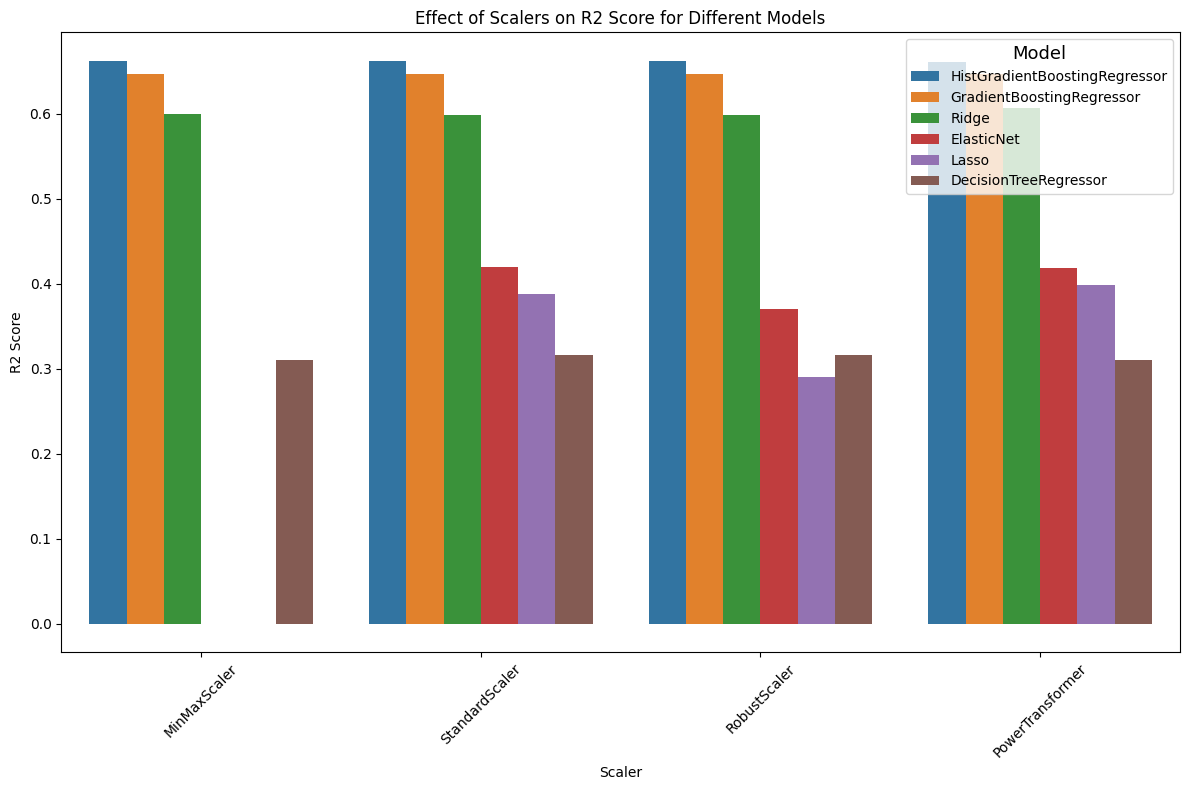

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert scores dictionary to R2_score
sorted_results_df['R2_score'] = sorted_results_df['scores'].apply(lambda x: x['R2_score'])

# Create barplot
plt.figure(figsize=(12, 8))
sns.barplot(data=sorted_results_df, x='scaler', y='R2_score', hue='model')

# Set plot labels and title
plt.xlabel('Scaler')
plt.ylabel('R2 Score')
plt.title('Effect of Scalers on R2 Score for Different Models')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='Model', title_fontsize='13')

# Show plot
plt.tight_layout()
plt.show()